# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [19]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [20]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


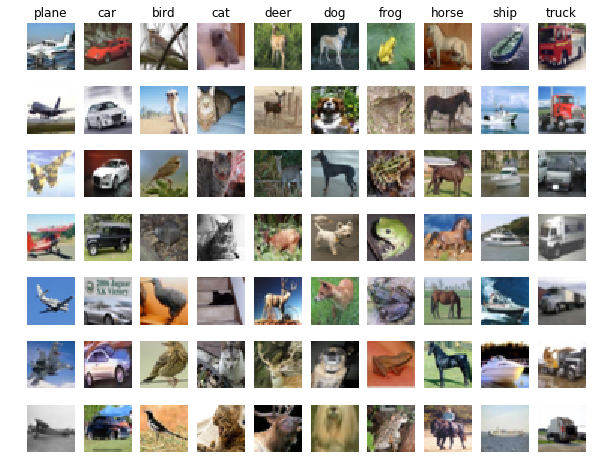

In [21]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [22]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [23]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


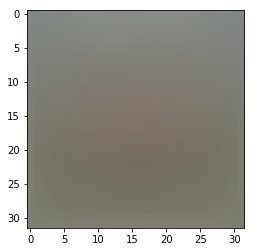

In [24]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [25]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [26]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [27]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.781518


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [28]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.037671 analytic: 7.037671, relative error: 2.232672e-11
numerical: -29.111302 analytic: -29.111302, relative error: 3.395430e-12
numerical: 22.688763 analytic: 22.688763, relative error: 2.693101e-12
numerical: -16.056000 analytic: -16.056000, relative error: 1.802467e-12
numerical: 0.057813 analytic: 0.057813, relative error: 3.103565e-09
numerical: -7.492425 analytic: -7.492425, relative error: 5.291291e-11
numerical: 13.450000 analytic: 13.450000, relative error: 3.081576e-11
numerical: 7.145509 analytic: 7.145509, relative error: 4.095155e-11
numerical: 38.735481 analytic: 38.735481, relative error: 6.526236e-12
numerical: 8.300000 analytic: 8.300000, relative error: 2.641946e-11
numerical: -0.592476 analytic: -0.597238, relative error: 4.002751e-03
numerical: 3.337673 analytic: 3.337267, relative error: 6.074073e-05
numerical: -4.860599 analytic: -4.862289, relative error: 1.737850e-04
numerical: 15.998477 analytic: 15.992673, relative error: 1.814172e-04
numerical: 2

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [29]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.781518e+00 computed in 0.140669s
Vectorized loss: 8.781518e+00 computed in 0.000000s
difference: 0.000000


In [30]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109387s
Vectorized loss and gradient: computed in 0.015658s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [44]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=100000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 100000: loss 407.026691
iteration 100 / 100000: loss 242.292475
iteration 200 / 100000: loss 146.745370
iteration 300 / 100000: loss 90.195023
iteration 400 / 100000: loss 56.515901
iteration 500 / 100000: loss 35.545048
iteration 600 / 100000: loss 23.405119
iteration 700 / 100000: loss 16.000647
iteration 800 / 100000: loss 11.655025
iteration 900 / 100000: loss 8.830444
iteration 1000 / 100000: loss 7.675023
iteration 1100 / 100000: loss 6.965489
iteration 1200 / 100000: loss 6.024479
iteration 1300 / 100000: loss 5.535850
iteration 1400 / 100000: loss 5.380091
iteration 1500 / 100000: loss 5.406544
iteration 1600 / 100000: loss 5.433642
iteration 1700 / 100000: loss 4.836585
iteration 1800 / 100000: loss 4.834650
iteration 1900 / 100000: loss 5.209155
iteration 2000 / 100000: loss 5.151788
iteration 2100 / 100000: loss 5.620259
iteration 2200 / 100000: loss 4.835161
iteration 2300 / 100000: loss 5.010714
iteration 2400 / 100000: loss 5.032828
iteration 2500 / 100000: 

iteration 20800 / 100000: loss 4.802738
iteration 20900 / 100000: loss 5.150982
iteration 21000 / 100000: loss 5.246475
iteration 21100 / 100000: loss 4.973162
iteration 21200 / 100000: loss 5.308666
iteration 21300 / 100000: loss 5.111948
iteration 21400 / 100000: loss 4.673960
iteration 21500 / 100000: loss 5.274319
iteration 21600 / 100000: loss 5.204590
iteration 21700 / 100000: loss 4.858505
iteration 21800 / 100000: loss 5.045477
iteration 21900 / 100000: loss 4.938481
iteration 22000 / 100000: loss 4.736900
iteration 22100 / 100000: loss 4.961724
iteration 22200 / 100000: loss 5.161898
iteration 22300 / 100000: loss 4.916813
iteration 22400 / 100000: loss 5.314222
iteration 22500 / 100000: loss 5.028608
iteration 22600 / 100000: loss 5.660213
iteration 22700 / 100000: loss 5.440369
iteration 22800 / 100000: loss 5.016738
iteration 22900 / 100000: loss 4.350875
iteration 23000 / 100000: loss 5.279891
iteration 23100 / 100000: loss 5.576555
iteration 23200 / 100000: loss 5.298044


iteration 41300 / 100000: loss 4.561904
iteration 41400 / 100000: loss 4.974121
iteration 41500 / 100000: loss 5.139317
iteration 41600 / 100000: loss 4.999306
iteration 41700 / 100000: loss 5.048913
iteration 41800 / 100000: loss 5.286979
iteration 41900 / 100000: loss 4.861757
iteration 42000 / 100000: loss 5.013506
iteration 42100 / 100000: loss 5.353932
iteration 42200 / 100000: loss 4.944572
iteration 42300 / 100000: loss 5.634147
iteration 42400 / 100000: loss 5.153795
iteration 42500 / 100000: loss 4.827703
iteration 42600 / 100000: loss 5.307231
iteration 42700 / 100000: loss 4.726979
iteration 42800 / 100000: loss 5.105880
iteration 42900 / 100000: loss 4.782355
iteration 43000 / 100000: loss 5.184725
iteration 43100 / 100000: loss 4.913720
iteration 43200 / 100000: loss 4.897043
iteration 43300 / 100000: loss 4.819793
iteration 43400 / 100000: loss 4.684823
iteration 43500 / 100000: loss 4.935804
iteration 43600 / 100000: loss 5.360603
iteration 43700 / 100000: loss 4.658390


iteration 61800 / 100000: loss 5.728538
iteration 61900 / 100000: loss 5.055015
iteration 62000 / 100000: loss 4.723487
iteration 62100 / 100000: loss 4.650541
iteration 62200 / 100000: loss 5.205376
iteration 62300 / 100000: loss 5.317201
iteration 62400 / 100000: loss 5.109743
iteration 62500 / 100000: loss 5.399222
iteration 62600 / 100000: loss 5.045208
iteration 62700 / 100000: loss 4.734136
iteration 62800 / 100000: loss 4.595614
iteration 62900 / 100000: loss 5.120481
iteration 63000 / 100000: loss 5.448401
iteration 63100 / 100000: loss 5.206211
iteration 63200 / 100000: loss 4.958739
iteration 63300 / 100000: loss 4.866431
iteration 63400 / 100000: loss 4.625122
iteration 63500 / 100000: loss 4.856702
iteration 63600 / 100000: loss 5.023957
iteration 63700 / 100000: loss 5.566347
iteration 63800 / 100000: loss 5.397413
iteration 63900 / 100000: loss 5.740975
iteration 64000 / 100000: loss 4.302354
iteration 64100 / 100000: loss 5.144146
iteration 64200 / 100000: loss 5.045805


iteration 82300 / 100000: loss 4.437572
iteration 82400 / 100000: loss 5.105456
iteration 82500 / 100000: loss 4.704409
iteration 82600 / 100000: loss 5.100706
iteration 82700 / 100000: loss 5.207215
iteration 82800 / 100000: loss 5.035199
iteration 82900 / 100000: loss 4.919051
iteration 83000 / 100000: loss 4.877006
iteration 83100 / 100000: loss 5.321333
iteration 83200 / 100000: loss 4.785701
iteration 83300 / 100000: loss 5.044914
iteration 83400 / 100000: loss 4.898502
iteration 83500 / 100000: loss 5.032517
iteration 83600 / 100000: loss 4.705195
iteration 83700 / 100000: loss 4.751718
iteration 83800 / 100000: loss 4.904206
iteration 83900 / 100000: loss 4.943724
iteration 84000 / 100000: loss 4.609893
iteration 84100 / 100000: loss 5.038708
iteration 84200 / 100000: loss 5.582613
iteration 84300 / 100000: loss 5.095768
iteration 84400 / 100000: loss 4.818082
iteration 84500 / 100000: loss 4.694368
iteration 84600 / 100000: loss 5.061901
iteration 84700 / 100000: loss 5.458312


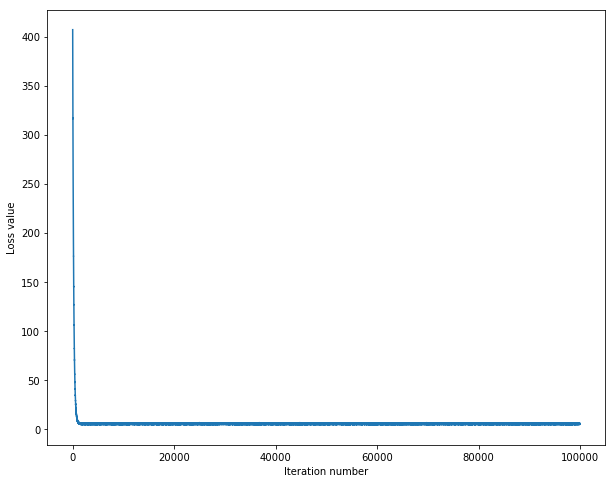

In [45]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [46]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.375367
validation accuracy: 0.381000


In [47]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.

#learning_rates = [1e-7, 5e-5]
#regularization_strengths = [2.5e4, 5e4]
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = [(1+i*0.1)*1e4 for i in range(-3,3)] + [(2+0.1*i)*1e4 for i in range(-3,3)]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, rs, num_iters=3000)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(lr,rs)] = train_accuracy, val_accuracy
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.400000e-07 reg 7.000000e+03 train accuracy: 0.393306 val accuracy: 0.402000
lr 1.400000e-07 reg 8.000000e+03 train accuracy: 0.398224 val accuracy: 0.393000
lr 1.400000e-07 reg 9.000000e+03 train accuracy: 0.393429 val accuracy: 0.371000
lr 1.400000e-07 reg 1.000000e+04 train accuracy: 0.390449 val accuracy: 0.391000
lr 1.400000e-07 reg 1.100000e+04 train accuracy: 0.394959 val accuracy: 0.384000
lr 1.400000e-07 reg 1.200000e+04 train accuracy: 0.388286 val accuracy: 0.389000
lr 1.400000e-07 reg 1.700000e+04 train accuracy: 0.383714 val accuracy: 0.374000
lr 1.400000e-07 reg 1.800000e+04 train accuracy: 0.385490 val accuracy: 0.383000
lr 1.400000e-07 reg 1.900000e+04 train accuracy: 0.379061 val accuracy: 0.387000
lr 1.400000e-07 reg 2.000000e+04 train accuracy: 0.376735 val accuracy: 0.376000
lr 1.400000e-07 reg 2.100000e+04 train accuracy: 0.384694 val accuracy: 0.393000
lr 1.400000e-07 reg 2.200000e+04 train accuracy: 0.381449 val accuracy: 0.381000
lr 1.500000e-07 reg 7.000000

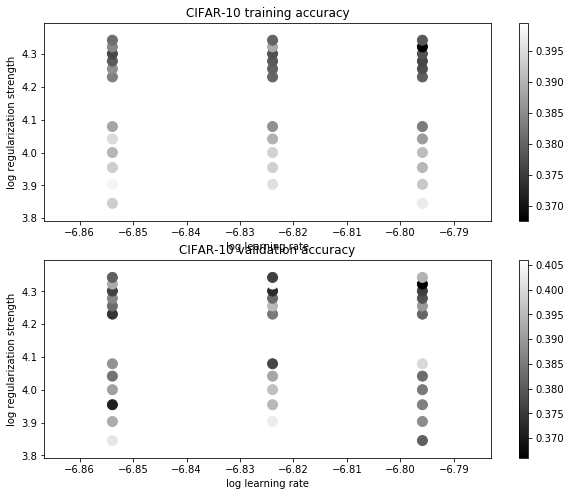

In [48]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [49]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


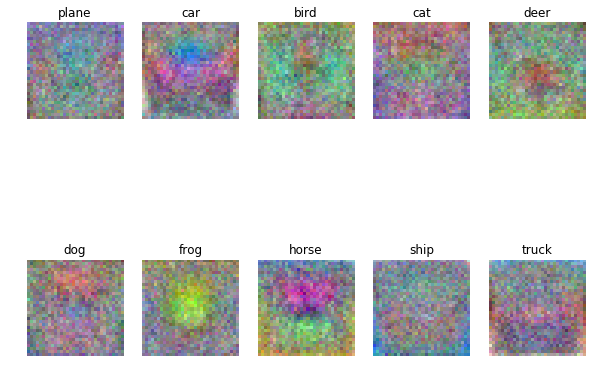

In [50]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*